<h3>Comments</h3>
- Rigor and Edits are a bit distorted since there is no way to get the edit history filtering out all non-user revisions (sometimes there might be slightly higher rigor than edits which is incorrect)<br>
- Pageviews are not correct. Now way to filter past article names and merge their views to the final title version of a wiki page<br>
- 

<br>

<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis Project Paper</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Predicting Movie Box Office Success Based on Wikipedia Activity</h4>
</div>
<br>

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
import json

### Wikipedia 2021 Movie List (Wikipedia Page Links)

In [29]:
def get_wiki_links(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.content, 'html.parser')
    new_url = soup.find('a', href=True, string='next page')['href']
    previous_url = url

    title = []
    wiki_link = []

    while True:

        previous_url = new_url
        letters = soup.findAll('div', {'class' : 'mw-category-group'})[14:]

        for entry in letters:
            movies = entry.findAll('li')

            for movie in movies:
                title.append(movie.string)
                wiki_link.append(movie.find('a')['href'])

        try:
            new_url = soup.find('a', href=True, string='next page')['href']
        except:
            break

        request = requests.get('https://en.wikipedia.org/' + new_url)
        soup = BeautifulSoup(request.content, 'html.parser')
        
    return pd.DataFrame({'title' : title, 'wiki_page' : wiki_link})

In [30]:
wiki_2020 = get_wiki_links('https://en.wikipedia.org/wiki/Category:2020_films')
wiki_2021 = get_wiki_links('https://en.wikipedia.org/wiki/Category:2021_films')

In [31]:
wiki_df = pd.concat([wiki_2020, wiki_2021], axis=0)

In [32]:
wiki_df['title'] = wiki_df['title'].str.replace(' \(.*\)', '', regex=True)
wiki_df['wiki_page'] = wiki_df['wiki_page'].str.replace('/wiki/', '')

In [36]:
#wiki_df.to_csv('data/wikipedia_links.csv', index=False)

### Domestic 2021 Boxofficemojo Moivies (400/408)

In [204]:
wiki_df = pd.read_csv('data/wikipedia_links.csv')

In [205]:
def get_bom_data():
    
    titles = []
    gross = []
    theaters = []
    opening = []
    release = []
    
    url = 'https://www.boxofficemojo.com/year/2021/?grossesOption=totalGrosses&sort=rank&sortDir='
    
    for link in ['asc', 'desc']:
        request = requests.get(url + link)
        soup = BeautifulSoup(request.content, 'html.parser')
        
        soup_rows = soup.find('div', {'id' : 'table'}).findAll('tr')

        for row in soup_rows:
            i = 0
            for cell in row.findAll('td'):

                if i == 1:
                    titles.append(cell.string)

                elif i == 5:
                    gross.append(cell.string)

                elif i == 6:
                    theaters.append(cell.string)

                elif i == 7:
                    opening.append(cell.string)

                elif i == 10:
                    date = cell.string + ', 2021'
                    date = datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
                    release.append(date)

                i += 1
                
    return pd.DataFrame({'title' : titles, 'gross_revenue': gross, 'n_theaters' : theaters, 'opening_revenue' : opening, 'release_date' : release})

In [208]:
df = get_bom_data()
df = df.merge(wiki_df, on='title').drop_duplicates('title')
df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage
3,Black Widow,"$183,651,655","4,275","$80,366,312",2021-07-09,Black_Widow_(2021_film)
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film)


### Retrieve Page Creation Date Via XTools API

In [37]:
def xtools_requests(wiki_page_name):
    url = 'https://xtools.wmcloud.org/api/page/articleinfo/en.wikipedia.org/'
    try:
        return requests.get(url + wiki_page_name)
    except:
        return 'Some error occured'

In [38]:
def get_edit_data(df, targe_column='wiki_page'):

    inceptions = []


    for i in df[targe_column]:
        data = xtools_requests(i)
        try:
            inceptions.append(data.json()['created_at'])
        except:
            inceptions.append(None)
            
    df['page_created_date'] = inceptions

In [39]:
get_edit_data(df)
df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings,2018-12-03
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage,2018-11-23
3,Black Widow,"$183,651,655","4,275","$80,366,312",2021-07-09,Black_Widow_(2021_film),2012-10-30
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film),2018-04-23


In [72]:
#df.to_csv('data/movies_meta_data.csv', index=False)

### Histograms

In [3]:
df = pd.read_csv('data/movies_meta_data.csv')
df['wiki_page'] = df['wiki_page'].str.replace('/', '%2F') # replace URL reserved character '/'
df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings,2018-12-03
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage,2018-11-23
3,Black Widow,"$183,651,655","4,275","$80,366,312",2021-07-09,Black_Widow_(2021_film),2012-10-30
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film),2018-04-23


In [4]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d')
df['page_created_date'] = pd.to_datetime(df['page_created_date'], format='%Y-%m-%d')

In [5]:
dist_day_created = (df['page_created_date'] - df['release_date']).dt.days

<Axes: ylabel='Count'>

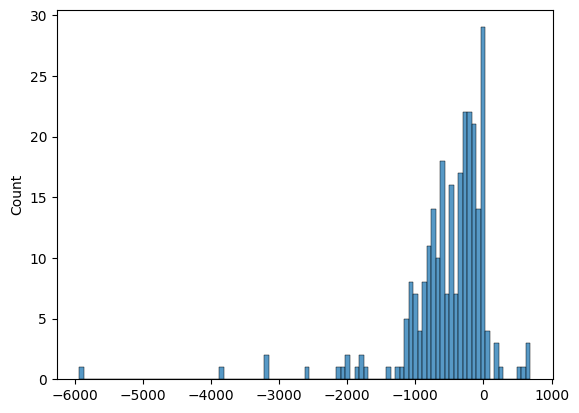

In [6]:
sns.histplot(dist_day_created, bins=100)

### Retrieve Edits -500 to +100 Days

#### Retrieve list of all Wikipedia Bots first to remove bot-edits from rigor statistic

In [99]:
def get_wiki_bots(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.content, 'html.parser')
    new_url = soup.find('a', href=True, string='next page')['href']
    previous_url = url

    bot_list = []

    while True:

        previous_url = new_url
        letters = soup.findAll('div', {'class' : 'mw-category mw-category-columns'})

        for entry in letters:
            bots = entry.findAll('li')

            for bot in bots:
                bot_list.append(bot.string[5:])

        try:
            new_url = soup.find('a', href=True, string='next page')['href']
        except:
            break

        request = requests.get('https://en.wikipedia.org/' + new_url)
        soup = BeautifulSoup(request.content, 'html.parser')
        
    return bot_list

In [102]:
wiki_bots = get_wiki_bots('https://en.wikipedia.org/wiki/Category:All_Wikipedia_bots')

In [112]:
# pd.DataFrame({'bot_name' : wiki_bots}).to_csv('data/wikipedia_bots.csv', index=False)

In [121]:
wiki_bots = list(pd.read_csv('data/wikipedia_bots.csv')['bot_name'])

#### Retreive edits

Example API Query:<br>
https://wikimedia.org/api/rest_v1/metrics/edits/per-page/en.wikipedia/Spider-Man%3A%20No%20Way%20Home/user/daily/20160101/20161231

In [7]:
df['cutoff_date_pre'] = df['release_date'] - timedelta(days=500)
df['cutoff_date_post'] = df['release_date'] + timedelta(days=100)

In [185]:
def calculate_aggregate_edits(page_history, start, end):
    date_range = pd.date_range(start, periods=600).tolist()
    
    edit_list = []
    edits = 1
    
    i = 1
    
    while page_history[i][0] < start:
        edits += 1
        
        i += 1
    
    for date in date_range:
        while page_history[i][0] == date:
            edits += 1
            i += 1
            
        edit_list.append(edits)
        
    return edit_list

In [186]:
def get_pageedit_data(df, target_column, start, end):
    
    collection = []
    edits = []
    i = 0
    
    for page in df[target_column]:   
        url = f'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&format=json&rvlimit=500&titles={page}'
        more_pages = ''
        
        revisions = []

        try:
            while True:
                data = requests.get(url + more_pages)
                page_id = list(data.json()['query']['pages'].keys())[0]

                revision = data.json()['query']['pages'][page_id]['revisions']

                for j in range(len(revision)):
                    timestamp = revision[j]['timestamp'][:10]
                    user = revision[j]['user']
                    if user not in wiki_bots:
                        revisions.append([datetime.strptime(timestamp, '%Y-%m-%d'), user])

                try:
                    rvcontinue = data.json()['continue']['rvcontinue']
                    more_pages = '&rvcontinue=' + rvcontinue
                except:
                    break

            revisions = revisions[::-1]
            collection.append(revisions)
            edits.append(calculate_aggregate_edits(revisions, df[start][i], df[end][i]))
        
        except:
            collection.append([])
            edits.append(['NaN'] * 600)
    
        i += 1
        
    return collection, edits

In [187]:
get_pageedit_data(test_df, 'wiki_page', 'cutoff_date_pre', 'cutoff_date_post')

([[[datetime.datetime(2016, 11, 10, 0, 0), 'Captain Assassin!'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [datetime.datetime(2019, 6, 10, 0, 0), '2.51.22.185'],
   [dat

In [178]:
def edits_requests(wiki_page, start, end):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    url = f'https://wikimedia.org/api/rest_v1/metrics/edits/per-page/en.wikipedia/{wiki_page}/all-editor-types/daily/{start}/{end}'
    try:
        return requests.get(url, headers=headers), url
    except:
        return 'Some error occured'

In [179]:
def get_edit_data(df, start_date, end_date, target_column = 'wiki_page'):
    edits = []
    i = 0
    
    start_dates = df[start_date].dt.strftime('%Y%m%d').to_list()
    inbetween_dates = (df[start_date] + timedelta(days=365)).dt.strftime('%Y%m%d').to_list()
    end_dates = df[end_date].dt.strftime('%Y%m%d').to_list()

    for page in df[target_column]:
        
        data, url = edits_requests(page, start_dates[i], inbetween_dates[i])
        try:
            a_data = data.json()['items'][0]
        except:
            pass
        
        data, url = edits_requests(page, inbetween_dates[i], end_dates[i])
        try:
            b_data = data.json()['items'][0]
            a_data['results'] = a_data['results'] + b_data['results']
            edits.append(a_data)
        except:
            print(data, page, url)
            edits.append({'page-title' : page, 'results' : []})
        
        i += 1
        
    return edits

In [180]:
daily_edits_per_page = get_edit_data(df, 'cutoff_date_pre', 'cutoff_date_post')

In [223]:
# with open('data/daily_edits_per_page.json', 'w', encoding='utf-8') as f:
#     json.dump(daily_edits_per_page, f, ensure_ascii=False, indent=4)
# f.close()

In [230]:
test = []
for movie in edit_history_output:
    test.append(len(movie['results']))

test.count(600) # We got 600 days of edit history for all of the 269 movies!

269

#### Create df containing the edit data

In [12]:
with open('data/daily_edits_per_page.json', 'r', encoding='utf-8') as f:
    daily_edits_per_page = json.loads(f.read())
f.close()

In [181]:
all_movie_edits_per_day = []

for movie in daily_edits_per_page:
    edits_per_day = []
    aggregate = 0
    for date in movie['results']:
        aggregate += date['edits']
        edits_per_day.append(aggregate)
    all_movie_edits_per_day.append(edits_per_day)

In [182]:
def get_corr_df(revenue_df, per_day_list):
    corr_df = pd.DataFrame(per_day_list, columns=list(range(-500, 100)))
    
    corr_df['opening_revenue'] = revenue_df['opening_revenue'].str.replace('$', '').str.replace(',', '').str.replace('-', 'NaN')
    corr_df['gross_revenue'] = revenue_df['gross_revenue'].str.replace('$', '').str.replace(',', '')
    
    return corr_df

In [183]:
edits_per_day_df = get_corr_df(df, all_movie_edits_per_day)
x = edits_per_day_df.corr().iloc[600, :600]

In [172]:
edits_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,0,0,0,0,1,1,1,1,1,2,...,5217,5220,5225,5229,5236,5242,5249,5270,260138569,804793477
1,1,1,1,1,1,1,1,1,4,5,...,1893,1897,1904,1910,1917,1921,1924,1927,75388688,224543292
2,1,2,2,2,2,5,5,5,5,5,...,1214,1214,1214,1220,1224,1225,1229,1231,90033210,213550366
3,0,0,0,3,3,5,5,5,6,7,...,2210,2212,2212,2216,2219,2221,2221,2222,80366312,183651655
4,0,0,0,0,1,2,2,2,2,2,...,2078,2079,2080,2081,2085,2085,2085,2085,71297219,164870234


In [17]:
# edits_per_day_df.to_csv('data/aggregated_edits_per_day.csv', index=False)

<Axes: ylabel='opening_revenue'>

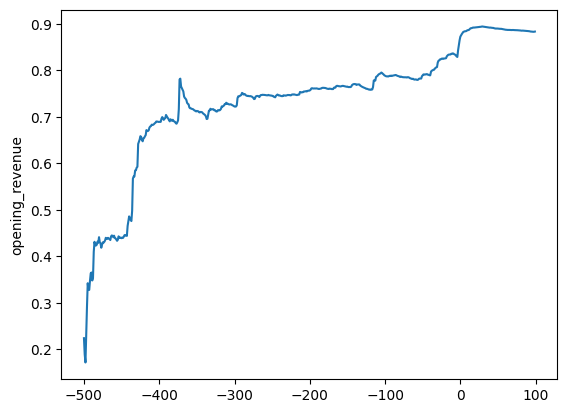

In [173]:
sns.lineplot(x)

### Retrieve Rigor Statistics -500 to +100 Days (Apply Algorithm to Calulate Rigor)

Example API Query:<br>
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&format=json&rvlimit=500&titles=MLK/FBI

In [142]:
def calculate_rigor_score(page_history, start, end):
    date_range = pd.date_range(start, periods=600).tolist()
    
    rigor_scores = []
    rigor_score = 1
    
    i = 1
    
    while page_history[i][0] < start:
        if page_history[i][1] != page_history[i-1][1]:
            rigor_score += 1
        else:
            if page_history[i][0] != page_history[i-1][0]:
                rigor_score += 1
            else:
                pass
        i += 1
    
    for date in date_range:
        while page_history[i][0] == date:
            if page_history[i][1] != page_history[i-1][1]:
                rigor_score += 1
            else:
                if page_history[i][0] != page_history[i-1][0]:
                    rigor_score += 1
                else:
                    pass
            i += 1
        rigor_scores.append(rigor_score)
        
    return rigor_scores

In [147]:
def get_rigorscore_data(df, target_column, start, end):
    
    collection = []
    rigor_scores = []
    i = 0
    
    for page in df[target_column]:   
        url = f'https://en.wikipedia.org/w/api.php?action=query&prop=revisions&format=json&rvlimit=500&titles={page}'
        more_pages = ''
        
        revisions = []

        try:
            while True:
                data = requests.get(url + more_pages)
                page_id = list(data.json()['query']['pages'].keys())[0]

                revision = data.json()['query']['pages'][page_id]['revisions']

                for j in range(len(revision)):
                    timestamp = revision[j]['timestamp'][:10]
                    user = revision[j]['user']
                    if user not in wiki_bots:
                        revisions.append([datetime.strptime(timestamp, '%Y-%m-%d'), user])

                try:
                    rvcontinue = data.json()['continue']['rvcontinue']
                    more_pages = '&rvcontinue=' + rvcontinue
                except:
                    break

            revisions = revisions[::-1]
            rigor_scores.append(calculate_rigor_score(revisions, df[start][i], df[end][i]))
            collection.append(revisions)
        
        except:
            collection.append([])
            rigor_scores.append(['NaN'] * 600)
    
        i += 1
        
    return rigor_scores, collection

In [148]:
daily_rigor_per_page, detailed_edit_history = get_rigorscore_data(df, 'wiki_page', 'cutoff_date_pre', 'cutoff_date_post')

In [174]:
rigor_per_day_df = get_corr_df(df, daily_rigor_per_page)
x = rigor_per_day_df.corr().iloc[600, :600]

In [176]:
rigor_per_day_df.head()

,-500,-499,-498,-497,-496,-495,-494,-493,-492,-491,...,92,93,94,95,96,97,98,99,opening_revenue,gross_revenue
0,175,175,175,175,176,176,176,176,177,178,...,4236,4239,4244,4248,4252,4258,4264,4279,260138569,804793477
1,297,297,297,297,297,297,297,297,300,302,...,1976,1979,1985,1992,2001,2005,2007,2010,75388688,224543292
2,358,360,360,360,360,362,362,364,364,364,...,1353,1353,1353,1357,1360,1361,1365,1367,90033210,213550366
3,1070,1070,1070,1074,1074,1076,1076,1076,1080,1082,...,2910,2912,2912,2915,2918,2920,2920,2921,80366312,183651655
4,866,866,866,866,869,870,870,870,870,870,...,2647,2648,2649,2650,2653,2653,2653,2653,71297219,164870234


In [ ]:
rigor_per_day_df.to_csv('data/aggregated_rigor_per_day.csv', index=False)

<Axes: ylabel='opening_revenue'>

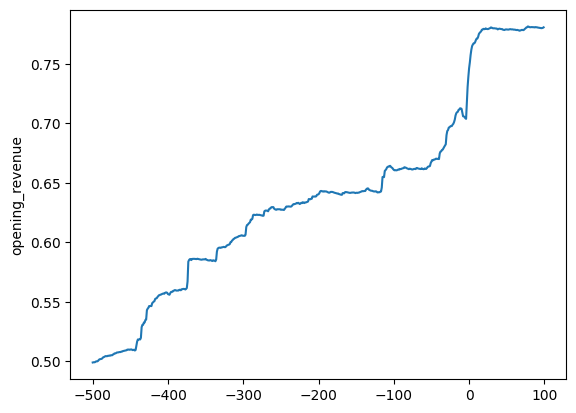

In [165]:
sns.lineplot(x)

### Retrieve Pageviews -500 to +100 Days (Error for movies where page created +100 days after release)

Example API Query:<br>
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Spider-Man:_No_Way_Home/daily/20200804/20210327

In [189]:
def pageviews_requests(wiki_page, start, end):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/{wiki_page}/daily/{start}/{end}'
    try:
        return requests.get(url, headers=headers), url
    except:
        return 'Some error occured'

In [190]:
def get_pageviews_data(df, start_date, end_date, target_column = 'wiki_page'):
    pageviews = []
    i = 0
    
    start_dates = df[start_date].dt.strftime('%Y%m%d').to_list()
    end_dates = df[end_date].dt.strftime('%Y%m%d').to_list()

    for page in df[target_column]:
        data, url = pageviews_requests(page, start_dates[i], end_dates[i])
        i += 1
        try:
            pageviews_page = data.json()['items']
        except:
            print(data, page, url)

        pageviews.append(pageviews_page)
        
    return pageviews

In [171]:
df.head()

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date,cutoff_date_pre,cutoff_date_post
0,Spider-Man: No Way Home,"$804,793,477","4,336","$260,138,569",2021-12-17,Spider-Man:_No_Way_Home,2016-11-10,2020-08-04,2022-03-27
1,Shang-Chi and the Legend of the Ten Rings,"$224,543,292","4,300","$75,388,688",2021-09-03,Shang-Chi_and_the_Legend_of_the_Ten_Rings,2018-12-03,2020-04-21,2021-12-12
2,Venom: Let There Be Carnage,"$213,550,366","4,225","$90,033,210",2021-10-01,Venom:_Let_There_Be_Carnage,2018-11-23,2020-05-19,2022-01-09
3,Black Widow,"$183,651,655","4,275","$80,366,312",2021-07-09,Black_Widow_(2021_film),2012-10-30,2020-02-25,2021-10-17
4,Eternals,"$164,870,234","4,090","$71,297,219",2021-11-05,Eternals_(film),2018-04-23,2020-06-23,2022-02-13


In [175]:
pageviews_json = get_pageviews_data(df, 'cutoff_date_pre', 'cutoff_date_post')

<Response [404]> The_Most_Reluctant_Convert
<Response [404]> If_I_Can%27t_Have_Love,_I_Want_Power_(film)
<Response [404]> The_Unthinkable_(2021_film)
<Response [404]> Slalom_(2020_film)
<Response [404]> Here_After_(film)
<Response [404]> Dark_State_(film)
<Response [404]> Mama_Weed
<Response [404]> MLK/FBI
<Response [404]> Last_Call_(2020_film)
<Response [404]> Kurt_Vonnegut:_Unstuck_in_Time


In [191]:
pageviews_json_2 = get_pageviews_data(df, 'cutoff_date_pre', 'cutoff_date_post')

<Response [404]> The_Most_Reluctant_Convert https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/The_Most_Reluctant_Convert/daily/20200621/20220211
<Response [404]> If_I_Can%27t_Have_Love,_I_Want_Power_(film) https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/If_I_Can%27t_Have_Love,_I_Want_Power_(film)/daily/20200412/20211203
<Response [404]> The_Unthinkable_(2021_film) https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/The_Unthinkable_(2021_film)/daily/20191224/20210815
<Response [404]> Slalom_(2020_film) https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Slalom_(2020_film)/daily/20191126/20210718
<Response [404]> Here_After_(film) https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Here_After_(film)/daily/20200310/20211031
<Response [404]> Dark_State_(film) https://wikimedia.org/a

In [193]:
df[df['wiki_page'] == 'Kurt_Vonnegut:_Unstuck_in_Time']

,title,gross_revenue,n_theaters,opening_revenue,release_date,wiki_page,page_created_date,cutoff_date_pre,cutoff_date_post
238,Kurt Vonnegut: Unstuck in Time,"$60,389",69,"$27,427",2021-11-19,Kurt_Vonnegut:_Unstuck_in_Time,2022-05-19,2020-07-07,2022-02-27


In [181]:
for i in pageviews:
    print(len(i))

397
601
601
390
601
601
601
601
601
601
601
483
601
601
601
601
543
601
75
581


https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Untitled%20Spider-Man%20sequel/daily/20160804/20220327

https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Spider-Man:_No_Way_Home/daily/20200804/20210327